In [27]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import LfuncN, LfuncAr, LfuncNe
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from LengyelReinkeFormulationMK import returnImpurityFracLengMK
from LengyelReinkeFormulationMKold import returnImpurityFracLengMKold
import os
import pickle as pkl
from timeit import default_timer as timer

from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF

%load_ext autoreload
%autoreload 2

fontsize = 12

plt.rc('font', size=fontsize) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize) #fontsize of the legend

def file_write(data, filename):
# Writes an object to a pickle file.
    with open(filename, "wb") as file:
    # Open file in write binary mode, dump result to file
        pkl.dump(data, file)
            
def file_read(filename):
# Reads a pickle file and returns it.
    with open(filename, "rb") as filename:
    # Open file in read binary mode, dump file to result.
        data = pkl.load(filename)
        
    return data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO and input reproduction

## Read grid

### High resolution

In [18]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
list_sides = ["iu", "ou"]
data = dict()
data_reverse = dict()
sepadd = 2
res = 500

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")
    data_reverse[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "midplane_to_target")

### Low resolution

In [28]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
list_sides = ["iu", "ou"]
data_lores = dict()
sepadd = 2
res = 100

for side in list_sides:
    data_lores[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")


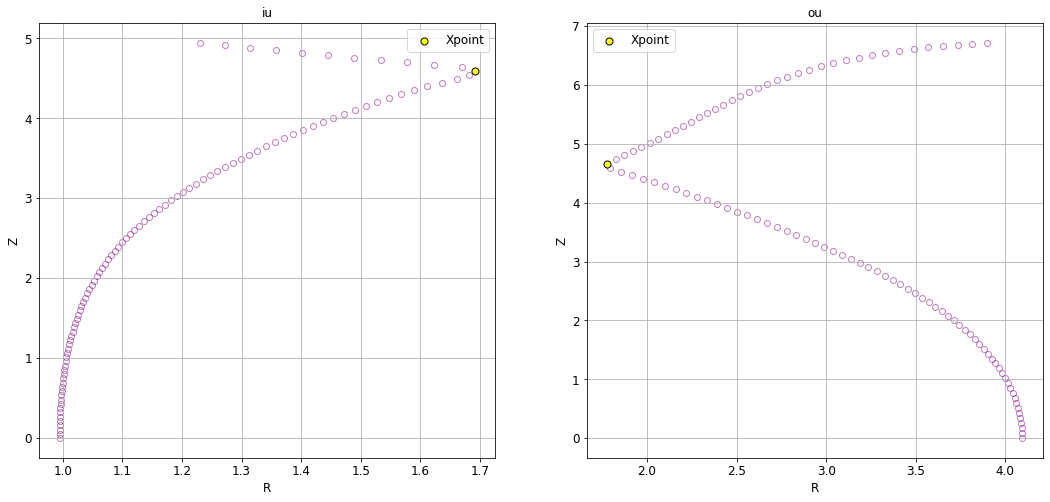

In [29]:
scale = 2; fig, ax = plt.subplots(1,2, figsize = (9*scale,4*scale))

xparam = "R"
yparam = "Z"

for i, side in enumerate(list_sides):
    d = data_lores[side]
    Xpoint = d["Xpoint"]
    ax[i].set_title(side)
    ax[i].plot(d[xparam], d[yparam], marker = "o", color = "None", markerfacecolor = "None", markeredgecolor = "purple", alpha = 0.5, zorder = 0)
    ax[i].scatter(d[xparam][Xpoint], d[yparam][Xpoint], marker = "o", s = 50, edgecolor = "black", color = "yellow", label = "Xpoint", zorder = 1)
    ax[i].legend(); ax[i].grid()
    ax[i].set_xlabel(xparam); ax[i].set_ylabel(yparam)

## Reproduce Ryoko's B profiles

Text(0.5, 1.0, 'Upper-outer divertor')

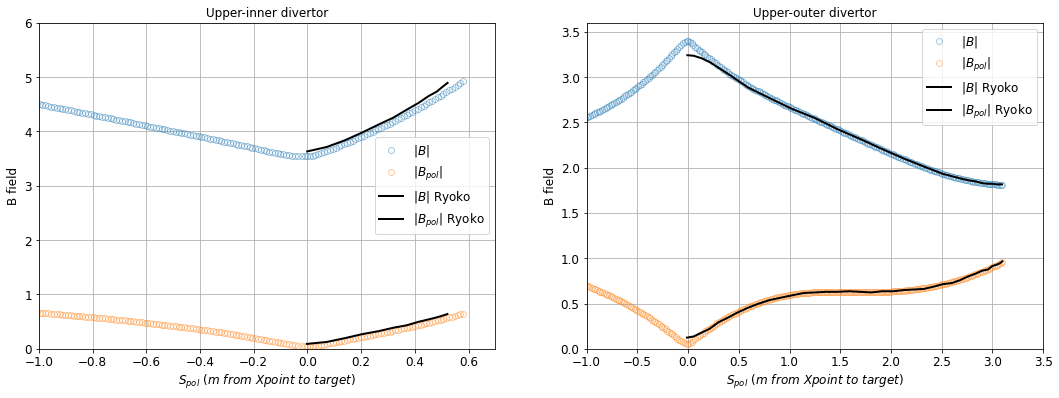

In [81]:
ryoko_dls_Btot = dict()
ryoko_dls_Bpol = dict()
ryoko_dls_Btot["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_iu_Btot.csv", header = None)
ryoko_dls_Btot["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_ou_Btot.csv", header = None)
ryoko_dls_Bpol["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_iu_Bpol.csv", header = None)
ryoko_dls_Bpol["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_B_ou_Bpol.csv", header = None)

fig, ax = plt.subplots(1,2, figsize=(18,6))

for i, side in enumerate(data_reverse.keys()):
    
    dr = data_reverse[side]
    Xpoint = dr["Xpoint"]
    # ax[i].plot(d["Spol"][Xpoint:]-d["Spol"][Xpoint], d["Btot"][Xpoint:], marker = "o", label = "$|B|$")
    # ax[i].plot(d["Spol"][Xpoint:]-d["Spol"][Xpoint], d["Bpol"][Xpoint:], marker = "o", label = "$|B_{pol}|$")
    
    # ax[i].plot(d["Spol_fromx"][::-1], d["Btot"], marker = "o", label = "$|B|$", linewidth = 0, alpha = 0.4)
    
    ax[i].plot(dr["Spol"]-dr["Spol"][Xpoint], dr["Btot"], marker = "o", label = "$|B|$", linewidth = 0, markerfacecolor = "None",alpha = 0.4)
    ax[i].plot(dr["Spol"]-dr["Spol"][Xpoint], dr["Bpol"], marker = "o", label = "$|B_{pol}|$", linewidth = 0, markerfacecolor = "None", alpha = 0.4)
    
    ax[i].plot(ryoko_dls_Btot[side][0], ryoko_dls_Btot[side][1], label = "$|B|$ Ryoko", color = "black", linewidth = 2)
    ax[i].plot(ryoko_dls_Bpol[side][0], ryoko_dls_Bpol[side][1], label = "$|B_{pol}|$ Ryoko", color = "black", linewidth = 2)
    
    ax[i].set_xlabel("$S_{pol}\ (m\ from\ Xpoint\ to\ target)$", fontsize = 12)
    ax[i].set_ylabel("B field")
    ax[i].legend()
    ax[i].grid()
    
ax[0].set_ylim(0,6)
ax[1].set_ylim(0,3.6)
ax[0].set_xlim(-1,0.7)
ax[1].set_xlim(-1,3.5)
ax[0].set_title("Upper-inner divertor")
ax[1].set_title("Upper-outer divertor")

## Plot downstream of Xpoint in Cyd's convention

Text(0.5, 1.0, 'Upper-outer divertor')

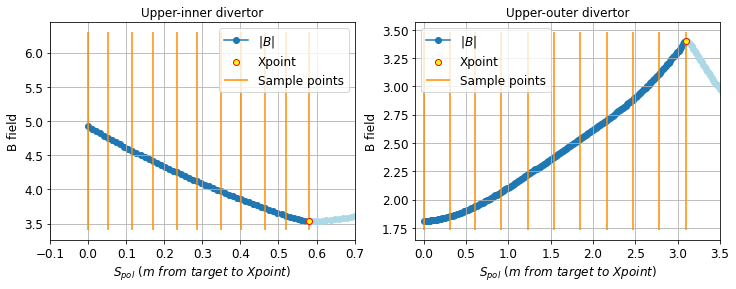

In [170]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

for i, side in enumerate(data.keys()):
    
    d = data[side]
    Xpoint = d["Xpoint"]
    indexrange = np.linspace(0, Xpoint, 11).astype(int)
    
    ax[i].plot(d["Spol"][:Xpoint+1], d["Btot"][:Xpoint+1], marker = "o", label = "$|B|$", zorder = 0)
    ax[i].scatter(d["Spol"][Xpoint], d["Btot"][Xpoint], marker = "o", label = "Xpoint", facecolor = "yellow", edgecolor = "red", zorder = 100)
    ax[i].plot(d["Spol"][Xpoint:], d["Btot"][Xpoint:], marker = "o", color = "lightblue")
    ylims = ax[i].get_ylim()
    ax[i].vlines([d["Spol"][x] for x in indexrange], ylims[0], ylims[1], color = "darkorange", label = "Sample points")
    
    ax[i].set_xlabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$", fontsize = 12)
    ax[i].set_ylabel("B field")
    ax[i].legend()
    ax[i].grid()
    
ax[0].set_xlim(-0.1, 0.7)
ax[1].set_xlim(-0.1, 3.5)

ax[0].set_title("Upper-inner divertor")
ax[1].set_title("Upper-outer divertor")

# Set defaults

In [7]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


    

# Cases

In [5]:
results = dict()

### Default settings

### Old code

In [222]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    # indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
    indexRange = [55]
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLengMKold(constants,radios,d["S"],indexRange, 
                                        acceleration = 2, verbose = False)

    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

results["old"] = out

Solving...55...Complete in 15.4 seconds
Solving...55...Complete in 15.9 seconds


### New code

In [8]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    solution = returnImpurityFracLengMK(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 1, verbosity = 0)
    out[side] = {**o, **solution} # merge dicts    
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

results["default"] = out

Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 18.9 seconds
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 19.3 seconds


### upstreamGrid = False

In [9]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
    radios["upstreamGrid"] = False
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    solution = returnImpurityFracLengMK(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 1, verbosity = 0)
    out[side] = {**o, **solution} # merge dicts    
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

results["upstreamGridFalse"] = out

Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 17.0 seconds
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 17.3 seconds


### Cut at Xpoint

In [10]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
    radios["upstreamGrid"] = False
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    solution = returnImpurityFracLengMK(constants,radios,d["S"][:d["Xpoint"]+2],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 1, verbosity = 0)
    out[side] = {**o, **solution} # merge dicts    
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

results["cutatxpoint"] = out

Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 11.6 seconds
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 13.6 seconds


### Baseline

In [11]:
# From Ryoko, email from 22/03/2022:
# Yes, I mainly used for the cases I sent.
# nu = 1.0e20; (m^{-3})
# qpllu = 1.0e9; (W/m^2)

out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
    radios["upstreamGrid"] = True
    constants["nu"] = 1e20
    constants["qpllu0"] = 1e9
    constants["Lfunc"] = LfuncAr
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    solution = returnImpurityFracLengMK(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 1, verbosity = 0)
    out[side] = {**o, **solution} # merge dicts    
    out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

results["base"] = out

Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 13.6 seconds
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 13.3 seconds


### Cyd's code

In [180]:
out = defaultdict(dict)

for side in data.keys():
    
    d = data[side]
    o = out[side]
    constants = constants_default.copy()
    radios = radios_default.copy()
    radios["upstreamGrid"] = True
    # indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
    indexRange = [55]
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    o["splot"],o["C"],o["Sprofiles"],o["Tprofiles"],o["Qprofiles"],o["log"] = returnImpurityFracLeng(constants,radios,d["S"],indexRange)

results["cyd"] = out

Solving...55...Complete in 45.9 seconds
Solving...55...Complete in 33.1 seconds


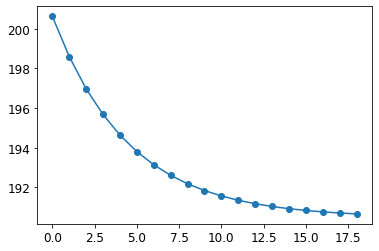

In [202]:
plt.plot(results["cyd"]["iu"]["log"][55]["Tu"], marker = "o")

In [12]:
file_write(results, "3b-ryokoreproduction.pkl")

# Postprocessing

In [13]:
for case in results.keys():
    for side in data.keys():
        o = results[case][side]
        d = data[side]
        o["Crel"] = o["C"]/o["C"][0]

ryoko_dls = dict(); ryoko_LRB = dict()
ryoko_dls["iu"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_iu.csv", header = None)
ryoko_dls["ou"] = pd.read_csv(os.getcwd()+r"\\csv\\ryoko_dls_ou.csv", header = None)
ryoko_LRB["iu"] = [[1,0.9953, 0.9893, 0.9827, 0.9765, 0.9715, 0.9694, 0.9724, 0.9856, 1.0206, 1.1242],
[0, 0.0799, 0.1481, 0.2139, 0.2755, 0.3322, 0.3835, 0.4286, 0.4669, 0.4977, 0.5215]]

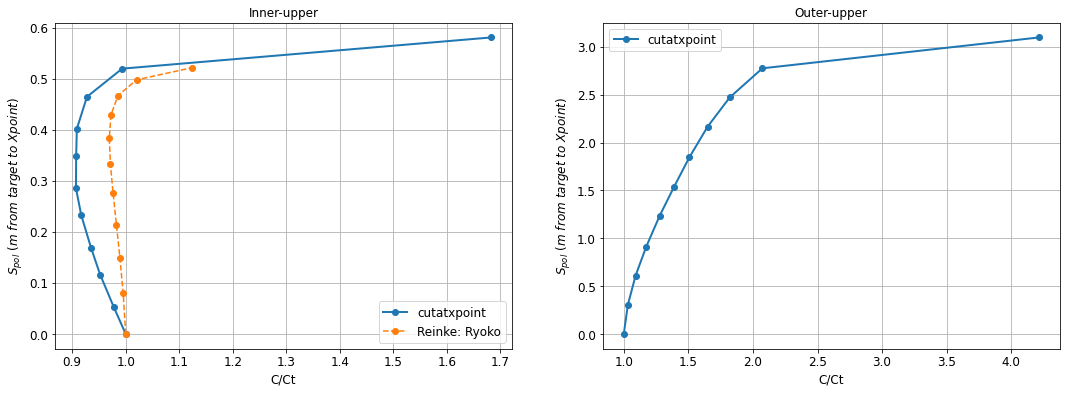

In [16]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

# plot_cases = ["default", "upstreamGridFalse", "cutatxpoint", "base"]
plot_cases=["cutatxpoint"]

ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")

for i, side in enumerate(data.keys()):
    d = data[side]
    for case in plot_cases:
        out = results[case]
        ax[i].plot(out[side]["Crel"], out[side]["SpolPlot"], label = case, linewidth = 2, marker = "o")
    
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    
ax[0].plot(ryoko_LRB["iu"][0], ryoko_LRB["iu"][1], marker = "o", label = "Reinke: Ryoko", linestyle = "dashed")

for a in ax:
    a.legend()

# Scans

## Density scan with N curve

In [296]:
density_scan = dict()

for density in [5e18, 1e19, 5e19, 1e20, 5e20, 10e20]:

    out = defaultdict(dict)

    for side in data.keys():
        print(f"Solving: {density}")
        d = data[side]
        o = out[side]
        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
        # indexRange=[27]
        radios["upstreamGrid"] = True
        constants["nu"] = density
        constants["qpllu0"] = 1e9
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        solution = returnImpurityFracLengMK(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 1, verbosity = 0)
        out[side] = {**o, **solution} # merge dicts    
        out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

    density_scan[density] = out

Solving: 5e+18
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 14.9 seconds
Solving: 5e+18
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 18.9 seconds
Solving: 1e+19
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 17.0 seconds
Solving: 1e+19
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 16.3 seconds
Solving: 5e+19
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 14.5 seconds
Solving: 5e+19
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 15.0 seconds
Solving: 1e+20
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 14.7 seconds
Solving: 1e+20
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 13.8 seconds
Solving: 5e+20
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 13.3 seconds
Solving: 5e+20
Solving...0...18...36...54...73...

In [297]:
file_write(density_scan, "3b-density_scan.pkl")

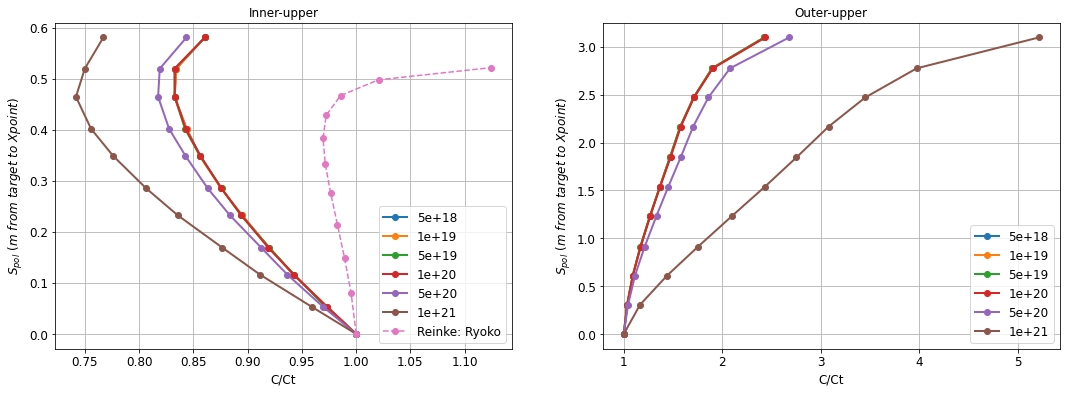

In [298]:
density_scan = file_read("3b-density_scan.pkl")

for case in density_scan.keys():
    for side in data.keys():
        o = density_scan[case][side]
        d = data[side]
        o["Crel"] = o["C"]/o["C"][0]
        
fig, ax = plt.subplots(1,2,figsize=(18,6))

plot_cases = ["default", "upstreamGridFalse", "cutatxpoint", "base"]

ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")

for i, side in enumerate(data.keys()):
    d = data[side]
    for case in density_scan.keys():
        out = density_scan[case]
        ax[i].plot(out[side]["Crel"], out[side]["SpolPlot"], label = case, linewidth = 2, marker = "o")
    
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    
ax[0].plot(ryoko_LRB["iu"][0], ryoko_LRB["iu"][1], marker = "o", label = "Reinke: Ryoko", linestyle = "dashed")

for a in ax:
    a.legend()

## Density scan with Ar curve

In [ ]:
density_scan_Ar = dict()

for density in [5e18, 1e19, 5e19, 1e20, 5e20, 10e20]:

    out = defaultdict(dict)

    for side in data.keys():
        print(f"Solving: {density}")
        d = data[side]
        o = out[side]
        constants = constants_default.copy()
        radios = radios_default.copy()
        indexRange = np.linspace(0, d["Xpoint"], 11).astype(int)
        # indexRange=[27]
        radios["upstreamGrid"] = True
        constants["nu"] = density
        constants["qpllu0"] = 1e9
        constants["Lfunc"] = LfuncAr
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        solution = returnImpurityFracLengMK(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 1, verbosity = 0)
        out[side] = {**o, **solution} # merge dicts    
        out[side]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]

    density_scan_Ar[density] = out

Solving: 5e+18
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 13.4 seconds
Solving: 5e+18
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 13.9 seconds
Solving: 1e+19
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 14.0 seconds
Solving: 1e+19
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 12.5 seconds
Solving: 5e+19
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 13.7 seconds
Solving: 5e+19
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 12.9 seconds
Solving: 1e+20
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 13.5 seconds
Solving: 1e+20
Solving...0...18...36...54...73...91...109...128...146...164...183...Complete in 13.9 seconds
Solving: 5e+20
Solving...0...5...11...16...22...27...33...38...44...49...55...Complete in 14.9 seconds
Solving: 5e+20
Solving...0...18...36...54...73...

In [309]:
file_write(density_scan_Ar, "3b-density_scan_Ar.pkl")

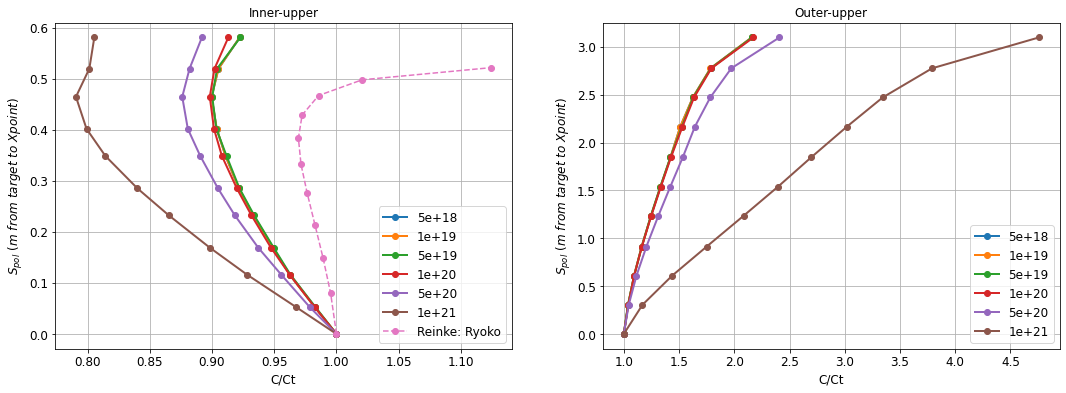

In [310]:
density_scan = file_read("3b-density_scan_Ar.pkl")

for case in density_scan_Ar.keys():
    for side in data.keys():
        o = density_scan_Ar[case][side]
        d = data[side]
        o["Crel"] = o["C"]/o["C"][0]
        
fig, ax = plt.subplots(1,2,figsize=(18,6))

plot_cases = ["default", "upstreamGridFalse", "cutatxpoint", "base"]

ax[0].set_title("Inner-upper"); ax[1].set_title("Outer-upper")

for i, side in enumerate(data.keys()):
    d = data[side]
    for case in density_scan_Ar.keys():
        out = density_scan_Ar[case]
        ax[i].plot(out[side]["Crel"], out[side]["SpolPlot"], label = case, linewidth = 2, marker = "o")
    
    # ax[i].plot(ryoko_dls[side][0], ryoko_dls[side][1], marker = "o", label = "DLS: Ryoko", linestyle = "dashed")
    ax[i].set_xlabel("C/Ct")
    ax[i].set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
    ax[i].grid()
    
ax[0].plot(ryoko_LRB["iu"][0], ryoko_LRB["iu"][1], marker = "o", label = "Reinke: Ryoko", linestyle = "dashed")

for a in ax:
    a.legend()